<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mathe\AppData\Local\Temp\ipykernel_11348\4095931039.py:36: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s+", " ", text)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


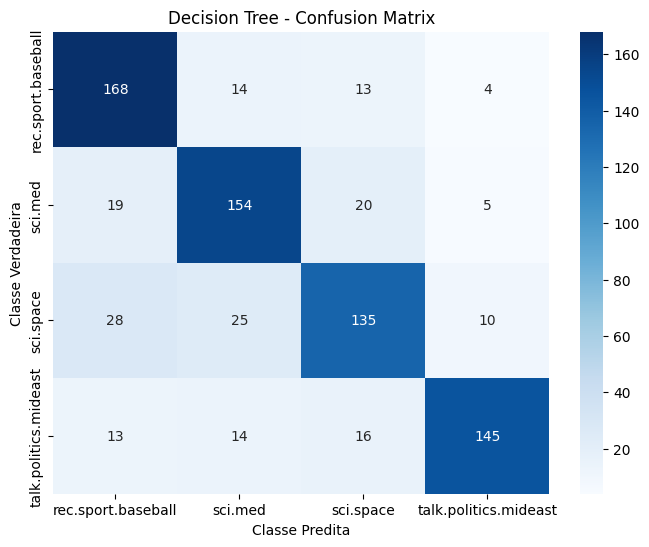

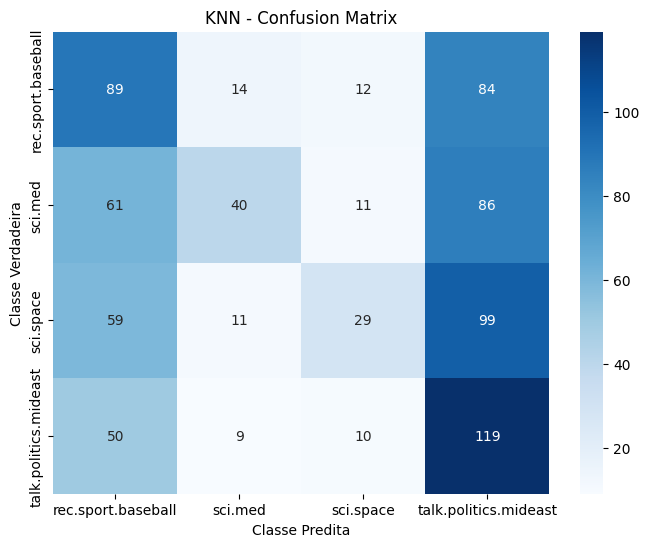

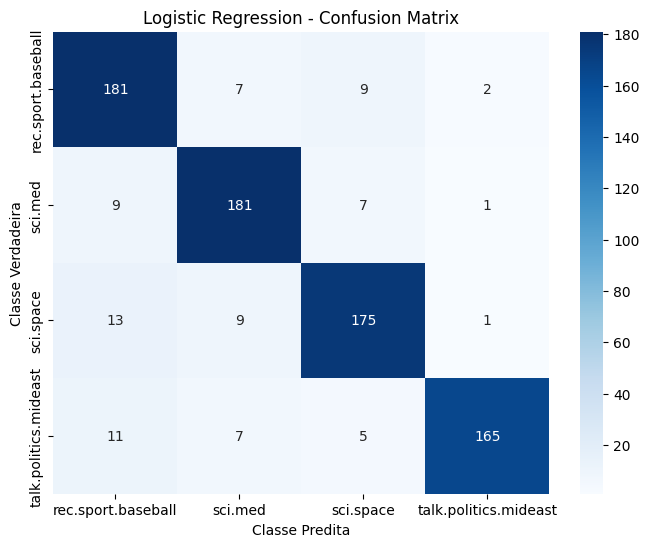

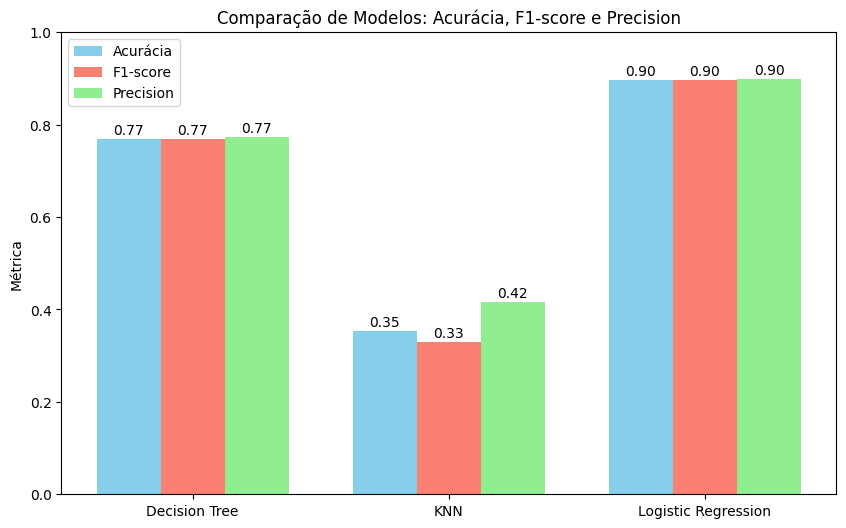


=== Conclusão ===
O modelo com melhor desempenho foi: Logistic Regression, com acurácia de 0.90, F1-score de 0.90 e Precision de 0.90.

Observações:
- O desempenho faz sentido considerando que o dataset é textual e algumas classes podem ter textos semelhantes.
- Logistic Regression tende a se sair bem com TF-IDF devido à alta dimensionalidade.

=== Melhorias Possíveis ===
- Aumentar o corpus de treinamento com mais dados.
- Usar lematização ou embeddings (Word2Vec, GloVe, BERT) para melhorar a representação do texto.
- Ajustar hiperparâmetros de forma mais detalhada (C, max_depth, n_neighbors).
- Aplicar redução de dimensionalidade (PCA ou TruncatedSVD) para KNN.
- Balanceamento de classes caso haja desbalanceamento.
- Validar usando k-fold cross-validation em todo o pipeline.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import fetch_20newsgroups

Dataset
categories = ['sci.space', 'sci.med', 'rec.sport.baseball', 'talk.politics.mideast']  # subset
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers','footers','quotes'))
df = pd.DataFrame({'Abstract': newsgroups.data, 'Category': [newsgroups.target_names[i] for i in newsgroups.target]})


stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_and_stem(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub("\s+", " ", text)
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

df['Abstract_clean'] = df['Abstract'].astype(str).apply(clean_and_stem)
df = df.dropna(subset=['Abstract_clean', 'Category'])

le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Abstract_clean'])
y = df['Category_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


results = {}

# -------- Árvore de Decisão --------
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')

results['Decision Tree'] = {'Accuracy': acc_dt, 'F1-score': f1_dt, 'Precision': precision_dt}

# -------- KNN --------
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')

results['KNN'] = {'Accuracy': acc_knn, 'F1-score': f1_knn, 'Precision': precision_knn}

# -------- Logistic Regression --------
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')

results['Logistic Regression'] = {'Accuracy': acc_lr, 'F1-score': f1_lr, 'Precision': precision_lr}

# ------------------- Matrizes de Confusão -------------------
for model_name, y_pred in zip(['Decision Tree','KNN','Logistic Regression'], [y_pred_dt, y_pred_knn, y_pred_lr]):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.show()

# ------------------- Comparação Gráfica -------------------
model_names = list(results.keys())
accuracy_values = [results[m]['Accuracy'] for m in model_names]
f1_values = [results[m]['F1-score'] for m in model_names]
precision_values = [results[m]['Precision'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, accuracy_values, width, label='Acurácia', color='skyblue')
plt.bar(x, f1_values, width, label='F1-score', color='salmon')
plt.bar(x + width, precision_values, width, label='Precision', color='lightgreen')

plt.xticks(x, model_names)
plt.ylim(0,1)
plt.ylabel('Métrica')
plt.title('Comparação de Modelos: Acurácia, F1-score e Precision')
plt.legend()

for i in range(len(model_names)):
    plt.text(x[i]-width, accuracy_values[i]+0.01, f"{accuracy_values[i]:.2f}", ha='center')
    plt.text(x[i], f1_values[i]+0.01, f"{f1_values[i]:.2f}", ha='center')
    plt.text(x[i]+width, precision_values[i]+0.01, f"{precision_values[i]:.2f}", ha='center')

plt.show()


best_model_name = max(results, key=lambda k: results[k]['Accuracy'])

print("\n=== Conclusão ===")
print(f"O modelo com melhor desempenho foi: {best_model_name}, "
      f"com acurácia de {results[best_model_name]['Accuracy']:.2f}, "
      f"F1-score de {results[best_model_name]['F1-score']:.2f} "
      f"e Precision de {results[best_model_name]['Precision']:.2f}.\n")

print("Observações:")
print("- O desempenho faz sentido considerando que o dataset é textual e algumas classes podem ter textos semelhantes.")
print("- Logistic Regression tende a se sair bem com TF-IDF devido à alta dimensionalidade.")

print("\n=== Melhorias Possíveis ===")
print("- Aumentar o corpus de treinamento com mais dados.")
print("- Usar lematização ou embeddings (Word2Vec, GloVe, BERT) para melhorar a representação do texto.")
print("- Ajustar hiperparâmetros de forma mais detalhada (C, max_depth, n_neighbors).")
print("- Aplicar redução de dimensionalidade (PCA ou TruncatedSVD) para KNN.")
print("- Balanceamento de classes caso haja desbalanceamento.")
print("- Validar usando k-fold cross-validation em todo o pipeline.")

